In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d obulisainaren/multi-cancer

Dataset URL: https://www.kaggle.com/datasets/obulisainaren/multi-cancer
License(s): CC-BY-NC-SA-4.0
100% 8.61G/8.62G [01:06<00:00, 145MB/s]
100% 8.62G/8.62G [01:06<00:00, 140MB/s]


In [ ]:
import zipfile
import os

zip_file_path = '/content/multi-cancer.zip'

extract_dir = '/content/'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
print("Contents of the extracted folder:")
for file in extracted_files:
    print(file)

Contents of the extracted folder:
.config
multi-cancer.zip
Multi Cancer
kaggle.json
sample_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import random
from os import listdir

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import  LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
dataPathTrain = "/content/Multi Cancer/Brain Cancer"
imageListTrain, labelListTrain = [], []

direcTrain = dataPathTrain
rootDirTrain = listdir(direcTrain)

# dataPathTest = "/content/"
# imageListTest, labelListTest = [], []

# direcTest = dataPathTest
# rootDirTest = listdir(direcTest)

In [ ]:
for directory in rootDirTrain:
    count = 0
    for files in listdir(f"{direcTrain}/{directory}"):
        count += 1
        image_path = f"{direcTrain}/{directory}/{files}"
        image = cv.imread(image_path)
        # image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)  # Read as grayscale for single channel
        image = cv.resize(image, (224, 224)) # can be used instead of reshape but can ruin the image when resized

        # image = keras.preprocessing.image.img_to_array(image)
        imageListTrain.append(image)
        labelListTrain.append(directory)
    print(directory, ":", count) # number of images in each class



brain_tumor : 5000
brain_menin : 5000
brain_glioma : 5000


In [ ]:
# # Reading and converting image to numpy array

# for directory in rootDirTest:
#   count = 0
#   for files in listdir(f"{direcTest}/{directory}"):
#     count += 1
#     image_path = f"{direcTest}/{directory}/{files}"
#     image = cv.imread(image_path)
#     # image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)  # Read as grayscale for single channel
#     image = cv.resize(image, (224, 224)) # can be used instead of reshape but can ruin the image when resized

#     # image = keras.preprocessing.image.img_to_array(image)
#     imageListTest.append(image)
#     labelListTest.append(directory)
#   print(directory, ":", count) # number of images in each class

# # print(len(labelListTest)) # number of images in each class
# # print(len(labelListTrain))
# # print(len(imageListTrain))
# # print(len(imageListTest))


In [ ]:
imageListTrain = np.array(imageListTrain)
# imageListTest = np.array(imageListTest)
labelListTrain=np.array(labelListTrain)
# labelListTest = np.array(labelListTest)
labelListTrain.shape

(15000,)

In [ ]:
train_data = list(zip(imageListTrain, labelListTrain))
random.seed(42)
random.shuffle(train_data)
imageListTrain, labelListTrain = zip(*train_data)

In [ ]:
imageListTrain, imageListTest, labelListTrain, labelListTest = train_test_split(imageListTrain, labelListTrain, test_size=0.2, random_state = 0)
print(f"Number of Training dataset: {len(imageListTrain)}\nNumber of Testing dataset: {len(imageListTest)}")

Number of Training dataset: 12000
Number of Testing dataset: 3000


In [ ]:
# Normalize and reshape data
imageListTrain = np.array(imageListTrain, dtype=np.float16) / 255.0
imageListTest = np.array(imageListTest, dtype=np.float16) / 255.0
imageListTrain = imageListTrain.reshape(-1, 224, 224, 3) # instead of cv.resize
imageListTest = imageListTest.reshape(-1, 224, 224, 3) # the number of images, the height of each image, the width of each image, number of channels.

In [ ]:
# Label binarizing to one hot encode the target variables
lb = LabelBinarizer()
labelListTrain = lb.fit_transform(labelListTrain)
labelListTest = lb.fit_transform(labelListTest)
print(lb.classes_)
labelListTest.shape

['brain_glioma' 'brain_menin' 'brain_tumor']


(3000, 3)

In [ ]:
early_stopping = callbacks.EarlyStopping(
        patience=10,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min',
        baseline=None,
    )
plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=4,
            verbose=0,
            mode='min')
CNN_model_checkpoint = callbacks.ModelCheckpoint('CNN_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)
VGG_model_checkpoint = callbacks.ModelCheckpoint('VGG_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)
Res50_model_checkpoint = callbacks.ModelCheckpoint('Res50_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)

# **Proposed CNN**

In [ ]:
def modelCNN():
    model = keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
CNN = modelCNN()

history = CNN.fit(imageListTrain , labelListTrain,
                validation_data = (imageListTest , labelListTest),
                epochs = 15,
                callbacks = [early_stopping , plateau, CNN_model_checkpoint],
              )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 415s 1s/step - loss: 0.4832 - accuracy: 0.8126 - val_loss: 0.3907 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 3/15
375/375 [==============================] - 417s 1s/step - loss: 0.4072 - accuracy: 0.8373 - val_loss: 0.4498 - val_accuracy: 0.8197 - lr: 0.0010
Epoch 4/15
375/375 [==============================] - 389s 1s/step - loss: 0.3437 - accuracy: 0.8643 - val_loss: 0.3065 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 5/15
375/375 [==============================] - 424s 1s/step - loss: 0.2705 - accuracy: 0.8968 - val_loss: 0.3154 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 6/15
375/375 [==============================] - 399s 1s/step - loss: 0.1913 - accuracy: 0.9254 - val_loss: 0.2888 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 7/15
375/375 [==============================] - 412s 1s/step - loss: 0.1337 - accuracy: 0.9487 - val_loss: 0.1770 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 8/15
375/375 [==============================] - 386s 1s/step - loss: 

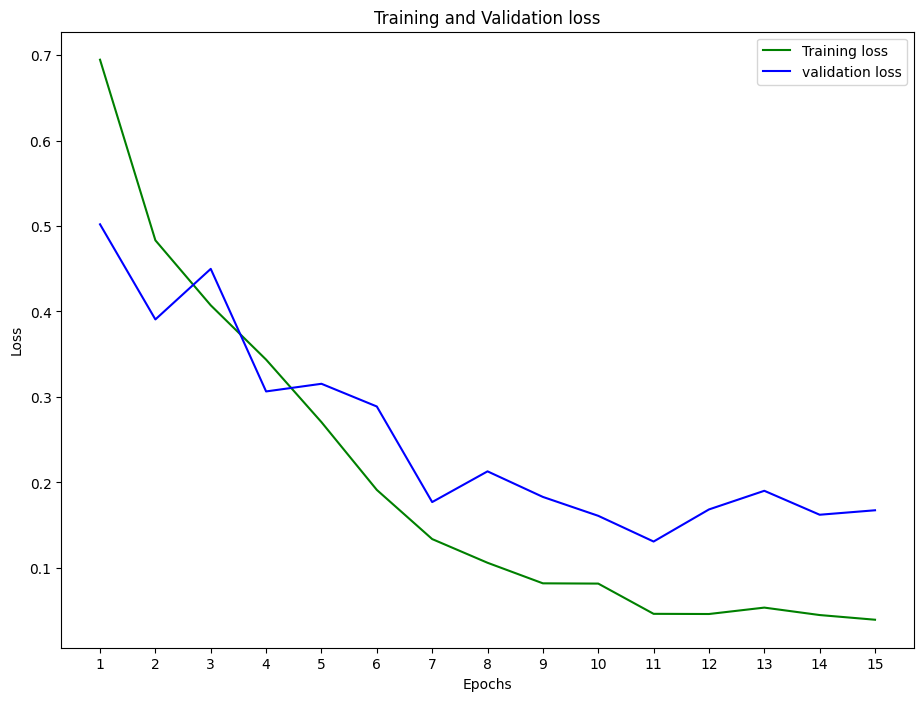

In [ ]:
r = 16
plt.figure(figsize=(11,8))
trainLossCNN = history.history['loss']
valLossCNN = history.history['val_loss']
epochs = range(1,r)
plt.plot(epochs, trainLossCNN, 'g', label='Training loss')
plt.plot(epochs, valLossCNN, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1,r))
plt.legend()
plt.show()

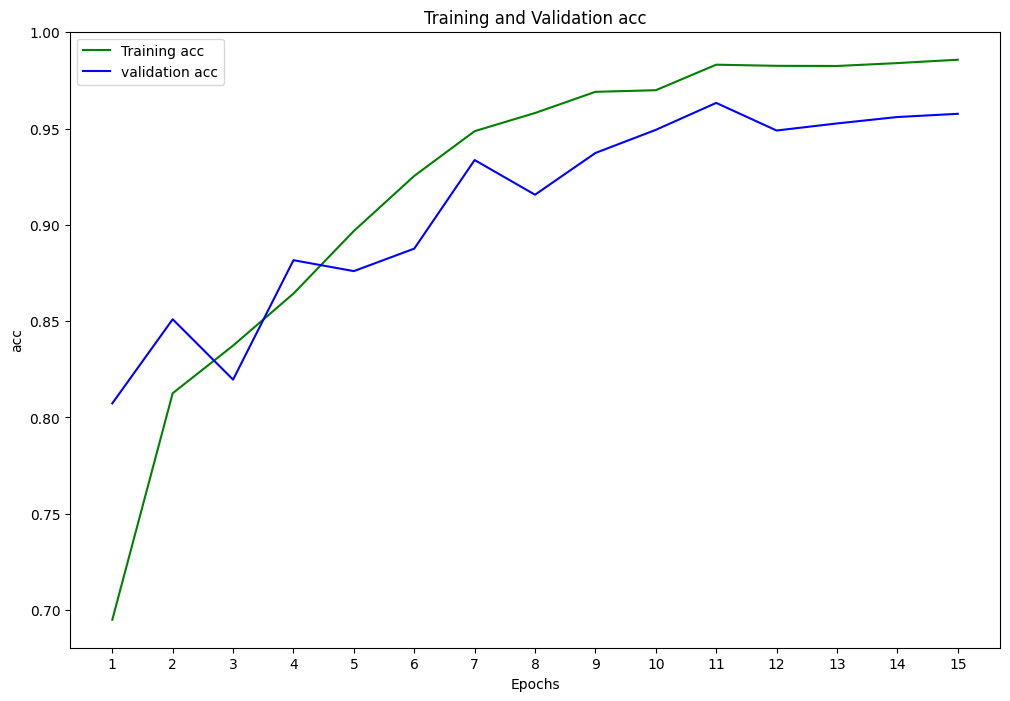

In [ ]:
plt.figure(figsize=(12,8))
trainAccCNN = history.history['accuracy']
valAccCNN = history.history['val_accuracy']
epochs = range(1,r)
plt.plot(epochs, trainAccCNN, 'g', label='Training acc')
plt.plot(epochs, valAccCNN, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.xticks(np.arange(1,r))
plt.legend()
plt.show()

In [ ]:
y_pred = CNN.predict(imageListTest)
y_predicted_labels = [np.argmax(i) for i in y_pred]
y_predicted_labels = np.array(y_predicted_labels)
y_predicted_labels.shape
y_predicted_labels

94/94 [==============================] - 26s 274ms/step


array([1, 1, 1, ..., 0, 2, 0])

In [ ]:
y_test_single = np.argmax(labelListTest, axis=1)
print("Shape of yTest:", y_test_single.shape)
print("Shape of y_predicted_labels_single:", y_predicted_labels.shape)

Shape of yTest: (3000,)
Shape of y_predicted_labels_single: (3000,)


In [ ]:
y_predicted_labels = y_predicted_labels.astype(np.int32)
cm = confusion_matrix(y_test_single, y_predicted_labels)
print(cm)

[[965  23   8]
 [ 26 934  50]
 [  6  14 974]]


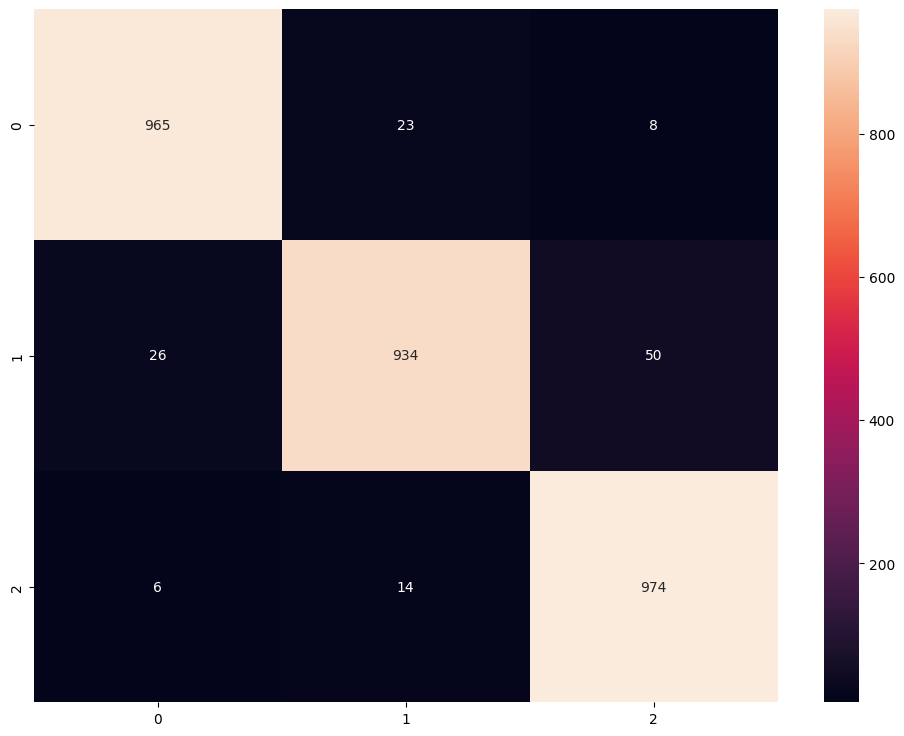

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
accuracy = np.mean(y_predicted_labels == y_test_single)
print("Accuracy:", accuracy)

Accuracy: 0.9576666666666667


In [ ]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
  print(f"Accuracy for class {i}: {acc}")

Accuracy for class 0: 0.9688755020080321
Accuracy for class 1: 0.9247524752475248
Accuracy for class 2: 0.9798792756539235


In [ ]:
print(classification_report(y_test_single, y_predicted_labels))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       996
           1       0.96      0.92      0.94      1010
           2       0.94      0.98      0.96       994

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test_single, y_predicted_labels, average='macro')
print("Precision:", precision)

recall = recall_score(y_test_single, y_predicted_labels, average='macro')
print("Recall:", recall)

f1 = f1_score(y_test_single, y_predicted_labels, average='macro')
print("F1 score:", f1)

acc = accuracy_score(y_test_single, y_predicted_labels)
print("Acc score:", acc)

Precision: 0.9578657048006094
Recall: 0.9578357509698269
F1 score: 0.9576159861072707
Acc score: 0.9576666666666667


# **VGG16**

In [ ]:
def VGG16BuiltFine():
  vgg16_model =  VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  vgg16_model.trainable = False
  model = Sequential([
       vgg16_model,
        Flatten(),
        Dense(1010, activation="relu"),
        Dropout(0.2, seed=2022),
        Dense(3, activation='softmax')
        ])
  model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
  model.summary()
  return model

In [ ]:
VGGF = VGG16BuiltFine()
history2 = VGGF.fit(
        imageListTrain, labelListTrain,
        validation_data = (imageListTest , labelListTest),
        epochs=15,
        callbacks = [early_stopping , plateau, VGG_model_checkpoint],
    )

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1010)              25339890  
                                                                 
 dropout (Dropout)           (None, 1010)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3033      
                                                                 
Total params: 40057611 (152.81 MB)
Trainable params: 25342923 (96.68 MB)
Non-trainable params: 14714688 (56.13 MB)
________

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 2271s 6s/step - loss: 0.4610 - accuracy: 0.8802 - val_loss: 0.1877 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 2/15
375/375 [==============================] - 2210s 6s/step - loss: 0.1478 - accuracy: 0.9451 - val_loss: 0.1345 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 3/15
375/375 [==============================] - 2250s 6s/step - loss: 0.1001 - accuracy: 0.9617 - val_loss: 0.2502 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 4/15
375/375 [==============================] - 2192s 6s/step - loss: 0.1014 - accuracy: 0.9599 - val_loss: 0.1503 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 5/15
375/375 [==============================] - 2198s 6s/step - loss: 0.0692 - accuracy: 0.9765 - val_loss: 0.1010 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 6/15
375/375 [==============================] - 2231s 6s/step - loss: 0.0691 - accuracy: 0.9751 - val_loss: 0.1204 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 7/15
375/375 [==============================] - 2193s 6s/step -

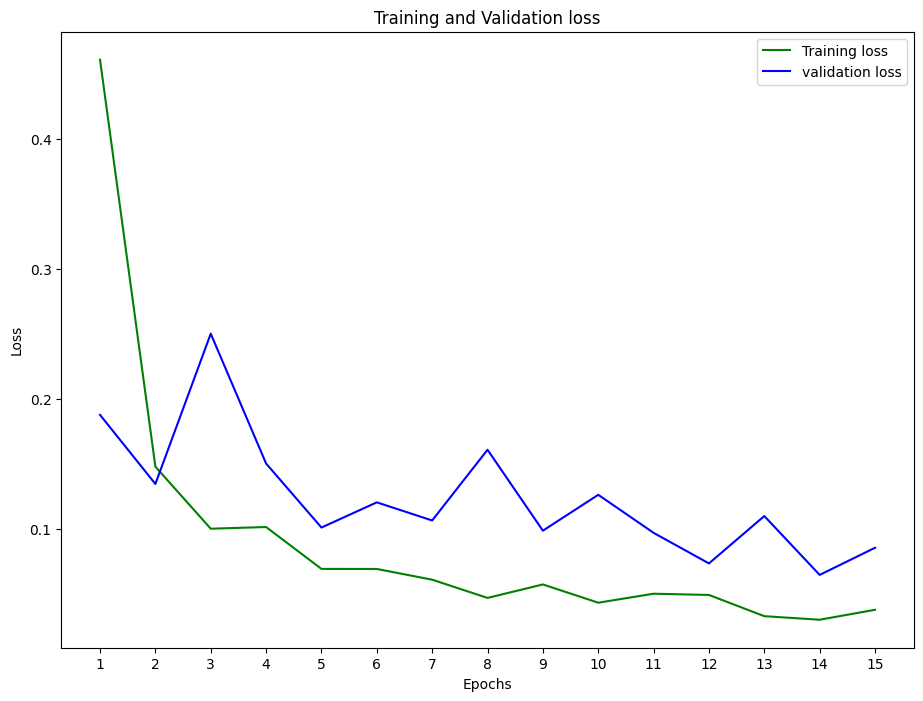

In [ ]:
r = 16
plt.figure(figsize=(11,8))
trainLossVGG = history2.history['loss']
valLossVGG = history2.history['val_loss']
epochs = range(1,r)
plt.plot(epochs, trainLossVGG, 'g', label='Training loss')
plt.plot(epochs, valLossVGG, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1,r))
plt.legend()
plt.show()

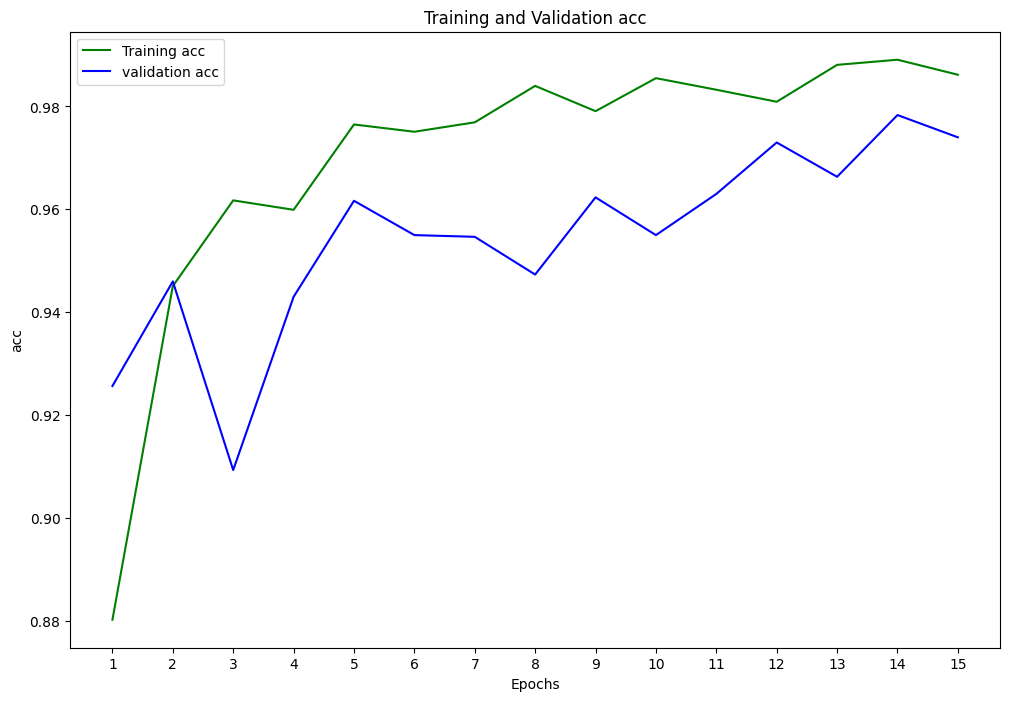

In [ ]:
plt.figure(figsize=(12,8))
trainAccVGG = history2.history['accuracy']
valAccVGG = history2.history['val_accuracy']
epochs = range(1,r)
plt.plot(epochs, trainAccVGG, 'g', label='Training acc')
plt.plot(epochs, valAccVGG, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.xticks(np.arange(1,r))
plt.legend()
plt.show()

In [ ]:
y_pred = VGGF.predict(imageListTest)
y_predicted_labels = [np.argmax(i) for i in y_pred]
y_predicted_labels = np.array(y_predicted_labels)
y_predicted_labels.shape
y_predicted_labels

94/94 [==============================] - 440s 5s/step


array([0, 0, 0, ..., 1, 2, 1])

In [ ]:
y_test_single = np.argmax(labelListTest, axis=1)
print("Shape of yTest:", y_test_single.shape)
print("Shape of y_predicted_labels_single:", y_predicted_labels.shape)

Shape of yTest: (3000,)
Shape of y_predicted_labels_single: (3000,)


In [ ]:
y_predicted_labels = y_predicted_labels.astype(np.int32)
cm = confusion_matrix(y_test_single, y_predicted_labels)
print(cm)

[[997  10   3]
 [ 10 954  32]
 [  3  20 971]]


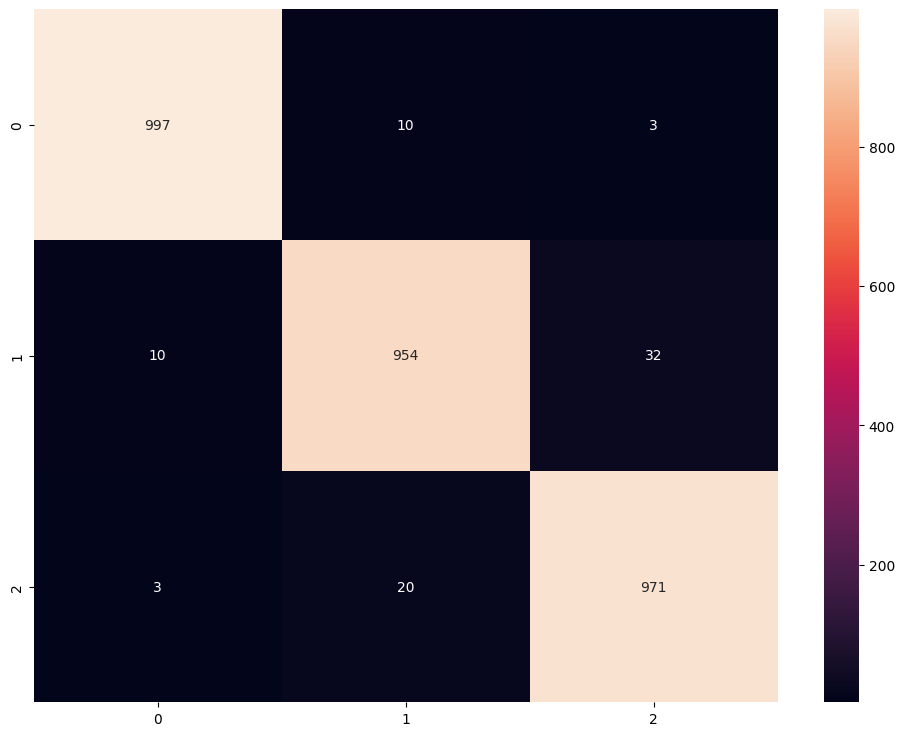

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
accuracy = np.mean(y_predicted_labels == y_test_single)
print("Accuracy:", accuracy)

Accuracy: 0.974


In [ ]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
  print(f"Accuracy for class {i}: {acc}")

Accuracy for class 0: 0.9871287128712871
Accuracy for class 1: 0.9578313253012049
Accuracy for class 2: 0.9768611670020121


In [ ]:
print(classification_report(y_test_single, y_predicted_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1010
           1       0.97      0.96      0.96       996
           2       0.97      0.98      0.97       994

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test_single, y_predicted_labels, average='macro')
print("Precision:", precision)

recall = recall_score(y_test_single, y_predicted_labels, average='macro')
print("Recall:", recall)

f1 = f1_score(y_test_single, y_predicted_labels, average='macro')
print("F1 score:", f1)

acc = accuracy_score(y_test_single, y_predicted_labels)
print("Acc score:", acc)

Precision: 0.973949885169383
Recall: 0.9739404017248346
F1 score: 0.9739216921692169
Acc score: 0.974


# **ResNet50**

In [ ]:
def res50Built():
    num_classes = 3
    model = Sequential([
        ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=3),
        Flatten(),
        Dense(500, activation="relu"),  # Adding the Hidden layer
        Dropout(0.1, seed=2022),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
Res50 = res50Built()
history3 = Res50.fit(
        imageListTrain, labelListTrain,
        validation_data = (imageListTest , labelListTest),
        epochs=15,
        callbacks = [early_stopping , plateau, Res50_model_checkpoint],
    )

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 500)               50176500  
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1503      
                                                                 
Total params: 73765715 (281.39 MB)
Trainable params: 73712595 (281.19 MB)
Non-trainable params: 53120 (207.50 KB)
_______

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 2528s 7s/step - loss: 1.0142 - accuracy: 0.8878 - val_loss: 3.6264 - val_accuracy: 0.3367 - lr: 0.0010
Epoch 2/15
375/375 [==============================] - 2308s 6s/step - loss: 0.2912 - accuracy: 0.9099 - val_loss: 1229.1448 - val_accuracy: 0.3367 - lr: 0.0010
Epoch 3/15
375/375 [==============================] - 2306s 6s/step - loss: 0.2678 - accuracy: 0.9097 - val_loss: 0.6803 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 4/15
375/375 [==============================] - 2307s 6s/step - loss: 0.4753 - accuracy: 0.8639 - val_loss: 0.3642 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 5/15
375/375 [==============================] - 2297s 6s/step - loss: 0.2179 - accuracy: 0.9236 - val_loss: 0.6299 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 6/15
375/375 [==============================] - 2285s 6s/step - loss: 0.2161 - accuracy: 0.9311 - val_loss: 2.7473 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 7/15
375/375 [==============================] - 2312s 6s/ste

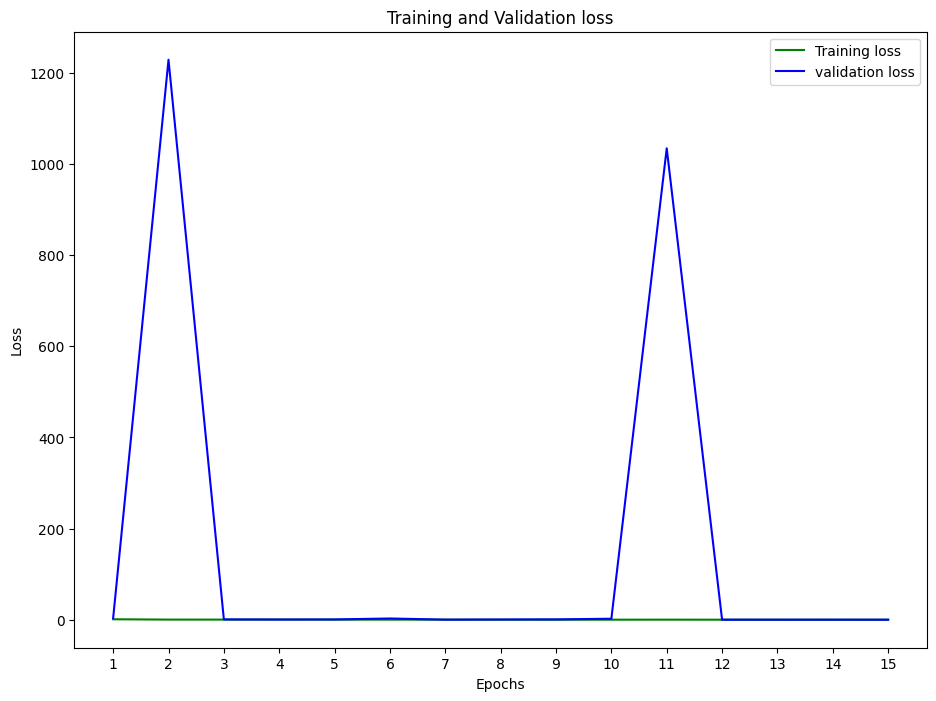

In [ ]:
r = 16
# Plot the loss and accuracy curves for training and validation
plt.figure(figsize=(11,8))
trainLossCNN = history3.history['loss']
valLossCNN = history3.history['val_loss']
epochs = range(1,r)
plt.plot(epochs, trainLossCNN, 'g', label='Training loss')
plt.plot(epochs, valLossCNN, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1,r))
plt.legend()
plt.show()

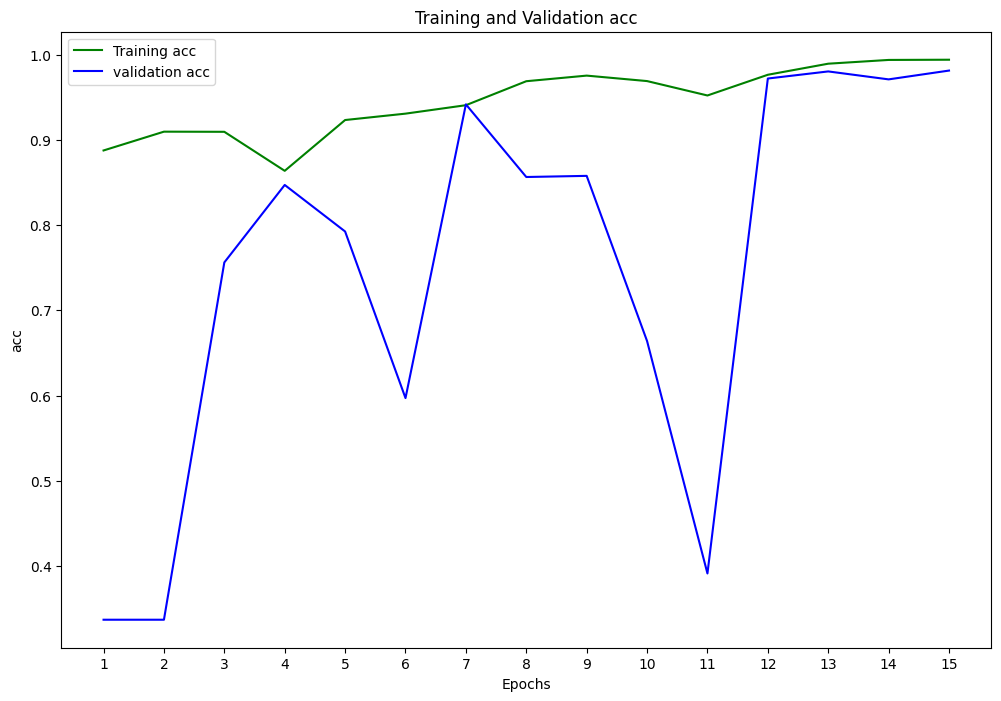

In [ ]:
#Plot the Accuarcy history
plt.figure(figsize=(12,8))
trainAccCNN = history3.history['accuracy']
valAccCNN = history3.history['val_accuracy']
epochs = range(1,r)
plt.plot(epochs, trainAccCNN, 'g', label='Training acc')
plt.plot(epochs, valAccCNN, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.xticks(np.arange(1,r))
plt.legend()
plt.show()

In [ ]:
y_pred = Res50.predict(imageListTest)
y_predicted_labels = [np.argmax(i) for i in y_pred]
y_predicted_labels = np.array(y_predicted_labels)
y_predicted_labels.shape
y_predicted_labels

94/94 [==============================] - 297s 3s/step


array([2, 2, 2, ..., 1, 0, 1], dtype=int64)

In [ ]:
y_test_single = np.argmax(labelListTest, axis=1)
print("Shape of yTest:", y_test_single.shape)
print("Shape of y_predicted_labels_single:", y_predicted_labels.shape)

Shape of yTest: (3000,)
Shape of y_predicted_labels_single: (3000,)


In [ ]:
y_predicted_labels = y_predicted_labels.astype(np.int32)
cm = confusion_matrix(y_test_single, y_predicted_labels)
print(cm)

[[ 991    3    0]
 [   2  990    4]
 [   1    1 1008]]


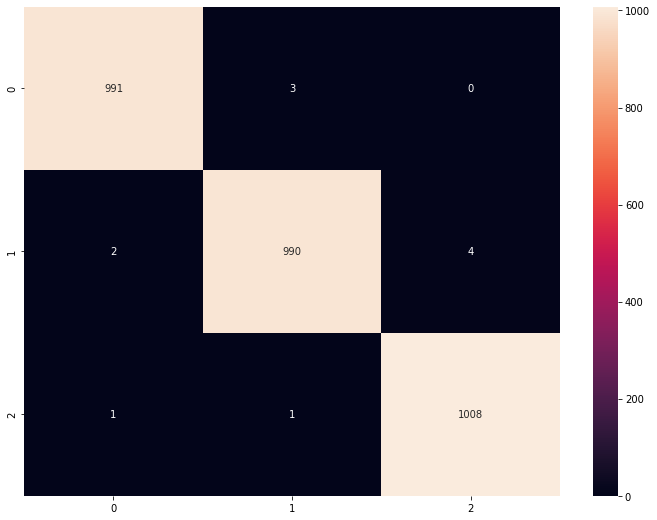

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
accuracy = np.mean(y_predicted_labels == y_test_single)
print("Accuracy:", accuracy)

Accuracy: 0.9963333333333333


In [ ]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
accs = {"CNN": [accuracy], "VGG16": [accuracy], "ResNet50": [accuracy]}
for i, acc in enumerate(class_accuracy):
  accs["CNN"].append(acc)
  print(f"Accuracy for class {i}: {acc}")

Accuracy for class 0: 0.9969818913480886
Accuracy for class 1: 0.9939759036144579
Accuracy for class 2: 0.998019801980198


In [ ]:
print(classification_report(y_test_single, y_predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       994
           1       1.00      0.99      0.99       996
           2       1.00      1.00      1.00      1010

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test_single, y_predicted_labels, average='macro')
print("Precision:", precision)

recall = recall_score(y_test_single, y_predicted_labels, average='macro')
print("Recall:", recall)

f1 = f1_score(y_test_single, y_predicted_labels, average='macro')
print("F1 score:", f1)

acc = accuracy_score(y_test_single, y_predicted_labels)
print("Acc score:", acc)

Precision: 0.996335059102971
Recall: 0.9963258656475814
F1 score: 0.9963298022231676
Acc score: 0.9963333333333333


In [31]:
! pip install tensorflow pillow ipywidgets

  Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [36]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import io
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import FileUpload, Image as WImage, VBox, Label

model = load_model('/content/Res50_best_model.h5')

def preprocess_image(image):
    img = image.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def make_prediction(image):
    img = preprocess_image(image)
    prediction = model.predict(img)
    return np.argmax(prediction, axis=1)[0]

def on_upload_change(change):
    uploader = change['owner']
    if uploader.value:
        file_info = uploader.value[list(uploader.value.keys())[0]]
        img_data = file_info['content']
        img = Image.open(io.BytesIO(img_data))

        img_widget = WImage(value=img_data, format='png', width=300, height=300)
        display(img_widget)

        prediction = make_prediction(img)
        result_label.value = f'Prediction: {prediction}'

uploader = FileUpload(
    accept='image/*',
    multiple=False
)

result_label = Label(value='Prediction: ')

uploader.observe(on_upload_change, names='value')

display(VBox([uploader, result_label]))

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

1/1 [==============================] - 1s 1s/step


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\…

1/1 [==============================] - 0s 125ms/step


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\…

1/1 [==============================] - 0s 109ms/step
